# 本研究中的模型

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import itertools
import warnings # 导入warnings模块

warnings.filterwarnings("ignore", category=UserWarning)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
# --- 数据加载 ---
# 定义列名
col_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
col_names += [f'sensor_{i}' for i in range(1, 22)]

# 加载数据
train_df = pd.read_csv("train_FD004.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD004.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD004.txt", sep="\s+", header=None, names=['RUL'])

print("训练数据尺寸:", train_df.shape)
print("测试数据尺寸:", test_df.shape)

训练数据尺寸: (61249, 26)
测试数据尺寸: (41214, 26)


In [3]:
# --- 1. 定义分段线性RUL函数 ---
def process_targets(data_length, early_rul=125):
    """根据给定的数据长度和早期RUL上限，创建目标RUL序列。"""
    # ... (这个函数保持不变，这里省略以保持简洁)
    if early_rul is None:
        return np.arange(data_length - 1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length - 1, -1, -1)
        else:
            return np.append(early_rul * np.ones(shape=(early_rul_duration,)), 
                             np.arange(early_rul - 1, -1, -1))

# --- 2. 核心修改：定义滑动窗口处理函数 ---
def process_input_data_with_targets(input_data, target_data=None, window_length=5, shift=1):
    """
    将时间序列数据转换为带有滑动窗口的样本。
    每个样本的特征将是窗口内数据的统计特征。
    """
    num_batches = np.int32(np.floor((len(input_data) - window_length) / shift)) + 1
    
    # 我们将为每个窗口创建统计特征
    # 特征包括：均值
    num_features = input_data.shape[1]
    num_stats = 1
    output_features = np.zeros((num_batches, num_features * num_stats))
    
    if target_data is None:
        # 仅处理特征（用于测试数据）
        for batch in range(num_batches):
            window = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
            # 计算统计特征
            means = np.mean(window, axis=0)
            # 将所有统计特征拼接成一个向量
            output_features[batch, :] = np.concatenate([means])
        return output_features
    else:
        # 同时处理特征和目标（用于训练数据）
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            window = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
            # 计算统计特征
            means = np.mean(window, axis=0)
            output_features[batch, :] = np.concatenate([means])
            # 目标是窗口最后一个点的RUL
            output_targets[batch] = target_data[(shift * batch + (window_length - 1))]
        return output_features, output_targets


# --- 3. 应用预处理 ---
# RUL计算和工况识别保持不变

rul = pd.DataFrame(train_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_number', 'max_cycles']
train_df = pd.merge(train_df, rul, on=['unit_number'], how='left')
train_df['RUL_actual'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop(columns=['max_cycles'], inplace=True)
early_rul_threshold = 125
rul_labels = train_df.groupby('unit_number')['RUL_actual'].apply(lambda x: process_targets(len(x), early_rul=early_rul_threshold))
train_df['RUL'] = rul_labels.explode().astype(int).values
train_df.drop(columns=['RUL_actual'], inplace=True)

sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
constant_cols = [col for col in sensor_cols if train_df[col].nunique() == 1]
features_to_use = [col for col in sensor_cols if col not in constant_cols]

def get_conditions(df):
    op_settings_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3']
    for col in op_settings_cols:
        df[col] = np.round(df[col], 0)
    df['condition'] = list(zip(df['op_setting_1'], df['op_setting_2'], df['op_setting_3']))
    return df

train_df = get_conditions(train_df)
test_df = get_conditions(test_df)

print("\n训练数据工况:")
print(train_df['condition'].unique())
print("\n测试数据工况:")
print(test_df['condition'].unique())
print("\n全部工况:")
print(sorted(list(set(train_df['condition'].unique()).union(set(test_df['condition'].unique())))))


训练数据工况:
[(42.0, 1.0, 100.0) (20.0, 1.0, 100.0) (25.0, 1.0, 60.0)
 (35.0, 1.0, 100.0) (0.0, 0.0, 100.0) (10.0, 0.0, 100.0)]

测试数据工况:
[(20.0, 1.0, 100.0) (25.0, 1.0, 60.0) (42.0, 1.0, 100.0)
 (35.0, 1.0, 100.0) (10.0, 0.0, 100.0) (0.0, 0.0, 100.0)]

全部工况:
[(0.0, 0.0, 100.0), (10.0, 0.0, 100.0), (20.0, 1.0, 100.0), (25.0, 1.0, 60.0), (35.0, 1.0, 100.0), (42.0, 1.0, 100.0)]


In [4]:


# 提取每个训练引擎的最后5个数据点
end_of_life_data = train_df.groupby('unit_number').tail(5).copy()

# 标准化特征数据
scaler = StandardScaler()
eol_scaled = scaler.fit_transform(end_of_life_data[features_to_use])
eol_scaled_df = pd.DataFrame(eol_scaled, index=end_of_life_data.index, columns=features_to_use)

# K-Means聚类
kmeans = KMeans(n_clusters=2, random_state=42)
end_of_life_data['failure_mode'] = kmeans.fit_predict(eol_scaled_df)

# 映射失效模式回主训练集
failure_mode_map = end_of_life_data.groupby('unit_number')['failure_mode'].agg(lambda x: x.value_counts().index[0])
train_df['failure_mode'] = train_df['unit_number'].map(failure_mode_map)

# --- 训练监督分类器 (例如 SVC) ---

# 准备训练数据：使用训练集末端数据和其对应的聚类标签
X_train_classifier = eol_scaled_df
y_train_classifier = end_of_life_data['failure_mode']

# 初始化并训练SVC模型
svc_classifier = SVC(random_state=42)
svc_classifier.fit(X_train_classifier, y_train_classifier)

# --- 为测试集预测失效模式 ---
# 获取测试集中每个引擎的最后一个数据点
test_last_point = test_df.groupby('unit_number').last().copy() # 使用 .copy() 避免 SettingWithCopyWarning

# 标准化测试集特征 (使用之前训练集上fit的scaler)
test_last_point_scaled = scaler.transform(test_last_point[features_to_use])
test_last_point_scaled_df = pd.DataFrame(test_last_point_scaled, index=test_last_point.index, columns=features_to_use)

# 使用训练好的SVC模型进行预测
test_failure_modes = svc_classifier.predict(test_last_point_scaled_df)

# 创建从 unit_number 到预测的 failure_mode 的映射
test_failure_map = dict(zip(test_last_point.index, test_failure_modes))

# 将预测的失效模式映射回整个测试集
test_df['failure_mode'] = test_df['unit_number'].map(test_failure_map)


# 检查是否有任何测试引擎没有被分配失效模式 (以防万一)
if test_df['failure_mode'].isnull().any():
    print("\n警告: 测试集中存在未分配失效模式的引擎。")
    print(test_df[test_df['failure_mode'].isnull()]['unit_number'].unique())
else:
    print("\n所有测试引擎均已成功分配失效模式。")

/Users/gaoyufei/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



所有测试引擎均已成功分配失效模式。


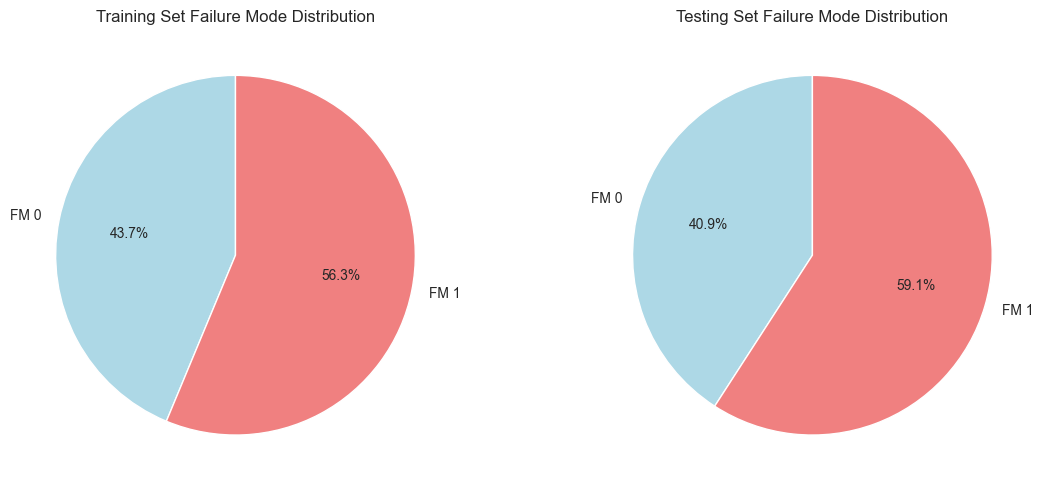

In [5]:
# 计算训练集中失效模式的分布
train_failure_counts = train_df['failure_mode'].value_counts().sort_index()
train_failure_prop = train_failure_counts / len(train_df['unit_number'].unique())

# 计算测试集中失效模式的分布
test_failure_counts = test_df['failure_mode'].value_counts().sort_index()
test_failure_prop = test_failure_counts / len(test_df['unit_number'].unique())

# 可视化比较
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 训练集饼图
ax1.pie(train_failure_counts.values, labels=[f'FM {i}' for i in train_failure_counts.index], 
    autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
ax1.set_title('Training Set Failure Mode Distribution')

# 测试集饼图
ax2.pie(test_failure_counts.values, labels=[f'FM {i}' for i in test_failure_counts.index], 
    autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
ax2.set_title('Testing Set Failure Mode Distribution')

plt.tight_layout()
plt.show()

In [6]:
# --- 定义滑动窗口参数 ---
window_length = 1
shift = 1

# --- 训练模型 (使用滑动窗口) ---
models = {}
all_conditions = sorted(list(set(train_df['condition'].unique()).union(set(test_df['condition'].unique()))))
failure_modes = train_df['failure_mode'].unique()

# 创建新的特征名称
stat_names = ['_mean']
stat_features_names = [f'{feat}{stat}' for stat in stat_names for feat in features_to_use]


for cond, fm in tqdm(list(itertools.product(all_conditions, failure_modes)), desc="训练模型"):
    
    # 筛选出当前组合的引擎ID
    train_subset_ids = train_df[(train_df['condition'] == cond) & (train_df['failure_mode'] == fm)]['unit_number'].unique()
    
    if len(train_subset_ids) == 0:
        continue
        
    all_X_train_engine = []
    all_y_train_engine = []
    
    # 对每个引擎应用滑动窗口处理
    for unit_id in train_subset_ids:
        engine_data = train_df[train_df['unit_number'] == unit_id]
        
        # 确保数据足够长以形成至少一个窗口
        if len(engine_data) < window_length:
            continue
            
        X_engine = engine_data[features_to_use].values
        y_engine = engine_data['RUL'].values
        
        X_processed, y_processed = process_input_data_with_targets(
            X_engine, y_engine, window_length=window_length, shift=shift
        )
        
        all_X_train_engine.append(X_processed)
        all_y_train_engine.append(y_processed)
        
    if not all_X_train_engine:
        continue

    # 合并所有引擎的数据
    X_train = np.concatenate(all_X_train_engine)
    y_train = np.concatenate(all_y_train_engine)

    # 训练模型
    rf_model = RandomForestRegressor(n_estimators=100, max_features="sqrt", n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train)
    models[(cond, fm)] = rf_model

# --- 预测与评估 (使用滑动窗口) ---
all_true_rul = []
all_predictions = []

for unit_id in tqdm(test_df['unit_number'].unique(), desc="预测测试集"):
    engine_data = test_df[test_df['unit_number'] == unit_id]
    
    # 提取最后一个窗口的数据
    # 确保有足够的数据来形成一个完整的窗口
    if len(engine_data) < window_length:
        print(f"警告: 测试引擎 {unit_id} 数据不足 ({len(engine_data)} < {window_length})，无法预测。")
        continue

    last_window_data = engine_data[features_to_use].values[-window_length:]
    
    # 使用处理函数生成最后一个窗口的统计特征
    X_test_sample = process_input_data_with_targets(last_window_data, window_length=window_length)

    # 获取该引擎的工况和失效模式
    cond = engine_data['condition'].iloc[-1]
    fm = engine_data['failure_mode'].iloc[-1]
    
    if (cond, fm) in models:
        model = models[(cond, fm)]
        
        # 将numpy数组包装成DataFrame以避免警告
        X_test_df = pd.DataFrame(X_test_sample, columns=stat_features_names)
        
        y_pred = model.predict(X_test_df)[0]
        y_true = true_rul_df.loc[unit_id - 1, 'RUL']
        
        all_predictions.append(y_pred)
        all_true_rul.append(y_true)
    else:
        print(f"警告：找不到引擎 {unit_id} 对应的模型 (工况: {cond}, 失效模式: {fm})。")

# --- 计算最终评估指标 ---
all_predictions = np.array(all_predictions)
all_true_rul = np.array(all_true_rul)

print("\n--- 评估结果 ---")
rmse = np.sqrt(mean_squared_error(all_true_rul, all_predictions))
print(f"整体均方根误差 (RMSE): {rmse:.4f}")

def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff / 13) - 1, np.exp(diff / 10) - 1))

s_score = compute_s_score(all_true_rul, all_predictions)
print(f"整体 S-score: {s_score:.4f}")

训练模型:   0%|          | 0/12 [00:00<?, ?it/s]

预测测试集:   0%|          | 0/248 [00:00<?, ?it/s]


--- 评估结果 ---
整体均方根误差 (RMSE): 30.2580
整体 S-score: 8078.1699


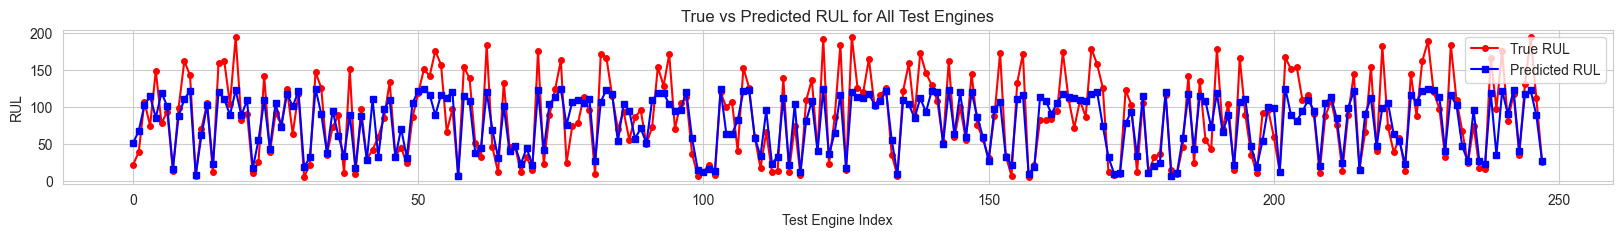

In [7]:
plt.figure(figsize=(20, 2))
plt.plot(all_true_rul, label="True RUL", color="red", marker='o', markersize=4)
plt.plot(all_predictions, label="Predicted RUL", color="blue", marker='s', markersize=4)
plt.xlabel('Test Engine Index')
plt.ylabel('RUL')
plt.title('True vs Predicted RUL for All Test Engines')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def plot_engine_prediction(unit_id, models_dict):
    """为指定的引擎绘制RUL预测曲线"""
    engine_data = train_df[train_df['unit_number'] == unit_id]
    if engine_data.empty:
        print(f"找不到引擎 {unit_id} 的数据。")
        return

    # 获取该引擎的工况和失效模式
    cond = engine_data['condition'].iloc[0]
    fm = engine_data['failure_mode'].iloc[0]

    if (cond, fm) not in models_dict:
        print(f"找不到引擎 {unit_id} 对应的模型。")
        return
    
    model = models_dict[(cond, fm)]
    
    # 对该引擎的每个时间点生成滑动窗口预测
    engine_features = engine_data[features_to_use].values
    predictions = []
    
    for i in range(len(engine_features) - window_length + 1):
        window = engine_features[i : i + window_length]
        
        # 生成统计特征
        processed_window = process_input_data_with_targets(window, window_length=window_length)
        
        # 包装成DataFrame
        processed_window_df = pd.DataFrame(processed_window, columns=stat_features_names)
        
        pred = model.predict(processed_window_df)[0]
        predictions.append(pred)

    # 准备绘图数据
    time_steps_for_pred = engine_data['time_in_cycles'].values[window_length-1:]
    true_rul_engine = engine_data['RUL'].values
    
    plt.figure(figsize=(10, 5))
    plt.plot(engine_data['time_in_cycles'], true_rul_engine, label='Piecewise Linear RUL (Ground Truth)', color='darkorange', lw=2)
    plt.plot(time_steps_for_pred, predictions, label='Predicted RUL (Sliding Window Model)', color='steelblue', linestyle='-')
    
    plt.title(f'Engine {unit_id}: Predicted RUL vs. Piecewise Linear RUL', fontsize=16)
    plt.xlabel('Time in Cycles', fontsize=14)
    plt.ylabel('Remaining Useful Life (RUL)', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


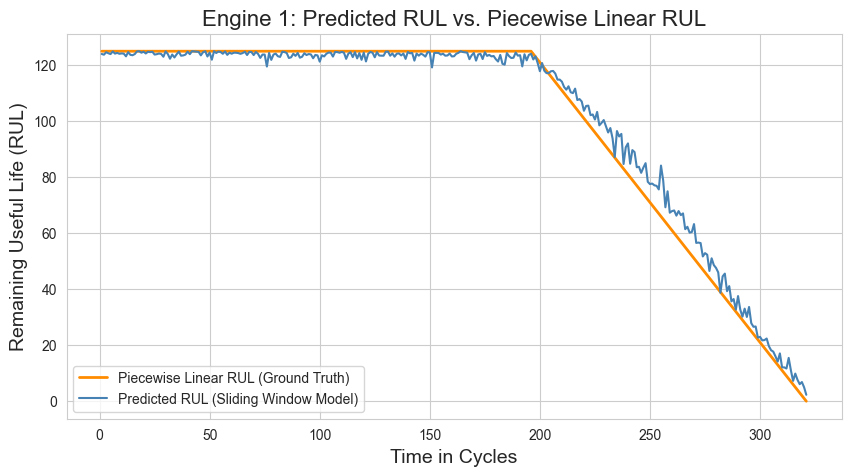

In [9]:
plot_engine_prediction(1, models)

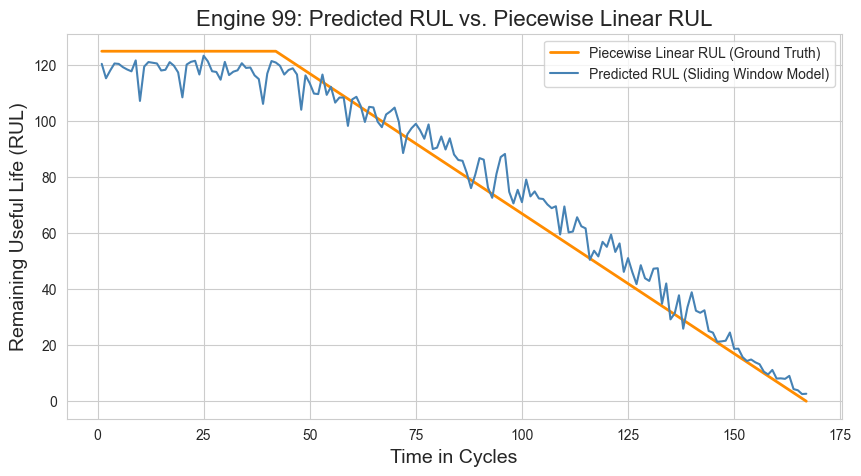

In [10]:
plot_engine_prediction(99, models)

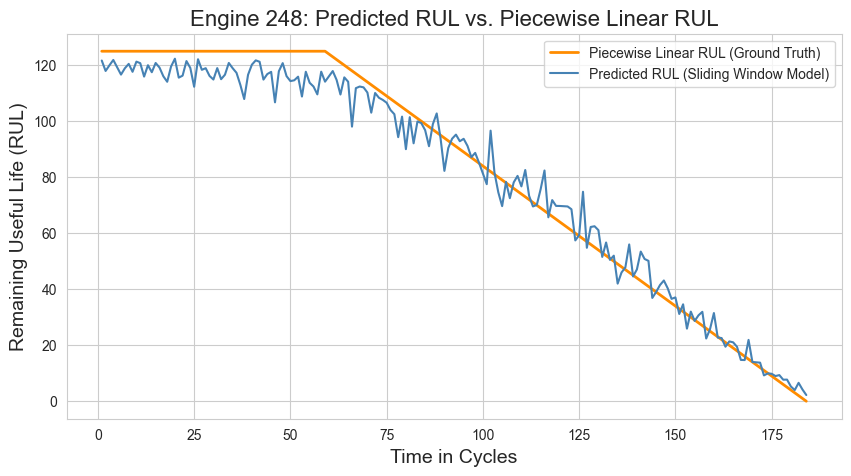

In [11]:
plot_engine_prediction(248, models)